In [1]:
import os
import csv
import glob
import time
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score
from sklearn.utils import resample

from xgboost import XGBClassifier


In [2]:
directory = r"data\20241104_layer0_sybil_features"

# Get a list of all CSV files in the directory
csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]

# Initialize an empty list to hold individual dataframes
dfs = []

# Loop through the CSV files and read each into a dataframe
for file in csv_files:
    file_path = os.path.join(directory, file)
    df = pd.read_csv(file_path)  # Assuming the CSV files have headers
    df.columns = map(str.lower, df.columns)
    #df = df.drop(columns=['rank', 'num_distinct_to_addresses'])
    dfs.append(df)

# Concatenate all dataframes into one
df = pd.concat(dfs, ignore_index=True)


# Data cleaning
df = df.drop(columns=['rank'], errors='ignore')
df['possible_triangles'] = df.in_degree * df.out_degree
df.drop(columns=['in_degree', 'out_degree'], inplace=True, errors='ignore') # Duplicated in "node metrics"
df = df[df.addr != '0x0000000000000000000000000000000000000000']

df_without_addr = df.drop(columns='addr').copy()
df_cleaned = df_without_addr.dropna(how='all').copy()
df_cleaned['addr'] = df.loc[df_cleaned.index, 'addr'].copy()
df = df_cleaned.copy()

df = df.drop_duplicates(subset=['addr'], keep='first')

In [3]:
directory = r"data\20241214_labeled_addresses"

csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]

labeled_addresses = set()

# Loop through the CSV files and read each into a dataframe
for file in csv_files:
    file_path = os.path.join(directory, file)
    with open(file_path, 'r') as f:
        labeled_addresses = labeled_addresses.union({line.strip() for line in f})
        

In [4]:
csv_directory = r"data\20241114_gas_provision\\"
to_from_mapping = {}

for csv_file in glob.glob(os.path.join(csv_directory, "*.csv")):
    with open(csv_file, mode="r") as file:
        reader = csv.DictReader(file)
        for row in reader:
            to_node = row.get("activated_address")
            from_node = row.get("gas_provider")
            if to_node and from_node:  # Ensure neither key nor value is empty
                to_from_mapping[to_node] = from_node

df["gas_provider"] = df["addr"].map(to_from_mapping)
df["provider_is_labeled"] = df["gas_provider"].apply(lambda gp: gp in labeled_addresses if gp else False)
val = set(df["addr"].values)
df["provider_is_interactor"] = df["gas_provider"].apply(lambda gp: gp in val if gp else False)
df["provider_is_null"] = df["gas_provider"].isnull()
df.drop(columns = ['gas_provider'], inplace=True)

In [5]:
df_gp = None
xs = []
files = glob.glob(r'data\20241117_tree_features\*.csv')

for file in files:
    x = pd.read_csv(file)  # Assuming the CSV files have headers
    x.columns = map(str.lower, x.columns)
    xs.append(x)

df_gp = pd.concat(xs, ignore_index=True)
df_gp.drop(columns = 'provider_is_labeled', inplace=True) # Column is incorrect in the file, correctly computed here.
df = df.merge(df_gp, on='addr', how='left')
df = df.fillna(0).copy()

In [15]:
df_gp = None
xs = []
files = glob.glob(r'data\20240915_final_sybil_list\*.csv')

for file in files:
    x = pd.read_csv(file)  # Assuming the CSV files have headers
    x.columns = map(str.lower, x.columns)
    xs.append(x)


address_df = pd.concat(xs)
address_df.columns = address_df.columns.str.lower()
address_df['address'] = address_df['address'].str.lower()
address_set = set(address_df['address'])

In [7]:
master_df = df.copy()
master_df['sybil'] = master_df['addr'].isin(address_set)
master_df_orig = master_df.copy()

In [8]:
def train_and_evaluate_model(X_train, y_train, X_val, y_val, selected_features, params):

    start_time = time.time()

    # Create and train the XGBoost classifier
    model = XGBClassifier(**params)
    
    
    model.fit(X_train[selected_features], y_train, verbose=False)

    # Make predictions on the validation set
    y_probs_val = model.predict_proba(X_val[selected_features])[:, 1]  # Get probabilities for the positive class
    y_pred = (y_probs_val > 0.5).astype(int)

    print("Confusion Matrix (Validation Set):")
    print(confusion_matrix(y_val, y_pred))

    print("\nClassification Report (Validation Set):")
    print(classification_report(y_val, y_pred, digits=3))

    precision, recall, thresholds = precision_recall_curve(y_val, y_probs_val)
    f1_scores = 2 * (precision * recall) / (precision + recall)

    # Find the optimal threshold based on the highest F1 score
    best_threshold = thresholds[np.argmax(f1_scores)]
    print(f"Optimal threshold (Validation Set): {best_threshold}")

    y_pred_optimal = (y_probs_val >= best_threshold).astype(int)

    print("\nConfusion Matrix (Optimal Threshold, Validation Set):")
    print(confusion_matrix(y_val, y_pred_optimal))

    print("\nClassification Report (Optimal Threshold, Validation Set):")
    print(classification_report(y_val, y_pred_optimal, digits=3))

    print("Time elapsed:", time.time() - start_time)

    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()
    
    feature_importances = model.get_booster().get_score(importance_type='weight')
    sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
    features = [item[0] for item in sorted_importances]
    importances = [item[1] for item in sorted_importances]

    # Plot the feature importances
    plt.figure(figsize=(10, 15))
    plt.barh(features, importances, color='skyblue')
    plt.xlabel("Feature Importance", fontsize=14)
    plt.ylabel("Features", fontsize=14)
    plt.title("Feature Importances from XGBoost", fontsize=16)
    plt.gca().invert_yaxis()  # Highest importance at the top
    plt.show()

    return model, best_threshold



def split_and_balance_data(df, label_column='sybil', test_size=0.3, val_size=0.3, random_state=42):
    # Separate features and labels
    X = df.drop(columns=[label_column])
    y = df[label_column]
    
    # Split into initial train and test sets
    X_train_initial, X_test, y_train_initial, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Further split the training set into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_initial, y_train_initial, test_size=val_size, random_state=random_state, stratify=y_train_initial
    )
    
    # Combine the training features and labels for balancing
    train_df = pd.concat([X_train, y_train], axis=1)
    
    # Separate the classes
    majority_class = train_df[train_df[label_column] == 0]
    minority_class = train_df[train_df[label_column] == 1]
    
    # Upsample the minority class
    minority_class_upsampled = resample(
        minority_class,
        replace=True,  # Sample with replacement
        n_samples=len(majority_class),  # Match the majority class size
        random_state=random_state  # Reproducible results
    )
    
    # Combine the balanced classes
    balanced_train_df = pd.concat([majority_class, minority_class_upsampled])
    
    # Separate balanced features and labels
    X_train_balanced = balanced_train_df.drop(columns=[label_column])
    y_train_balanced = balanced_train_df[label_column]
    
    return X_train_balanced, y_train_balanced, X_val, y_val, X_test, y_test



In [9]:
params = {
    'objective': 'binary:logistic',
    'random_state': 42,
    'eval_metric': 'logloss',  
    'n_estimators' :2000
}

selected_features = [
    "min_tx_value_out",
    "leaf_gas_distribution_entropy",
    "longest_chain_ratio",
    "provider_fan_out",
    "l0_to_eth_max_stargate_swap",
    "l0_avg_native_drop_usd",
    "l0_max_native_drop_usd",
    "l0_to_eth_tx_time_span",
    "leaf_gas_distribution_skewness",
    'max_depth', #"max_depth_in_tree",
    "balance_factor",
    "l0_to_eth_avg_stargate_swap",
    "tree_size",
    "star_like_ratio",
    "branching_factor",
    "earliest_l0_to_eth_tx_time",
    "l0_max_stargate_swap",
    "l0_tx_time_span",
    "earliest_tx_block_in",
    "n_l0_dest_contracts",
    "max_tx_value_in",
    "latest_l0_tx_time",
    "num_transactions",
    "gas_distribution_entropy",
    "n_l0_txs",
    "out_degree_per_block_out",
    "gas_distribution_skewness",
    "avg_tx_value_in",
    "latest_l0_to_eth_tx_time",
    "n_l0_source_chains",
    "n_l0_dest_chains",
    "n_eth_interactions",
    "tx_value_per_block_out",
    "earliest_l0_tx_time",
    "depth",
    "indegree_per_block_in"
]



Confusion Matrix (Validation Set):
[[86595   886]
 [ 1044  2780]]

Classification Report (Validation Set):
              precision    recall  f1-score   support

       False      0.988     0.990     0.989     87481
        True      0.758     0.727     0.742      3824

    accuracy                          0.979     91305
   macro avg      0.873     0.858     0.866     91305
weighted avg      0.978     0.979     0.979     91305

Optimal threshold (Validation Set): 0.554721474647522

Confusion Matrix (Optimal Threshold, Validation Set):
[[86658   823]
 [ 1075  2749]]

Classification Report (Optimal Threshold, Validation Set):
              precision    recall  f1-score   support

       False      0.988     0.991     0.989     87481
        True      0.770     0.719     0.743      3824

    accuracy                          0.979     91305
   macro avg      0.879     0.855     0.866     91305
weighted avg      0.979     0.979     0.979     91305

Time elapsed: 47.3853394985199


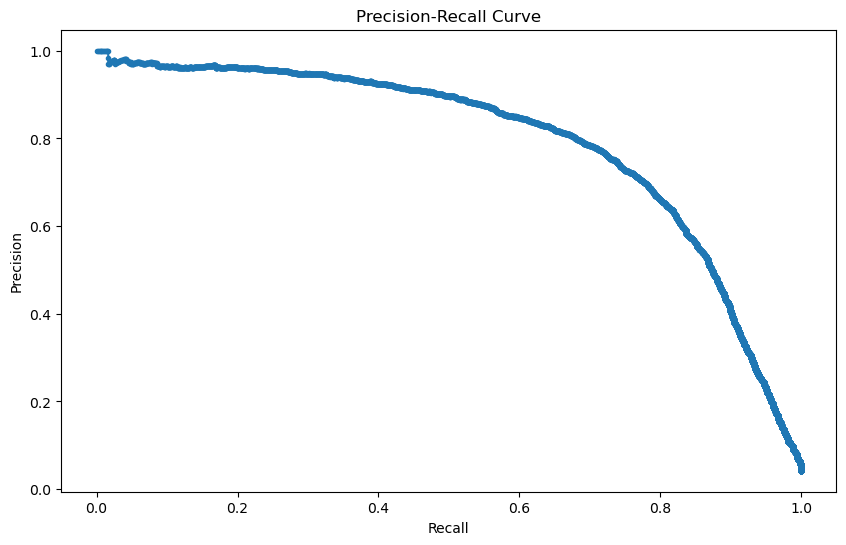

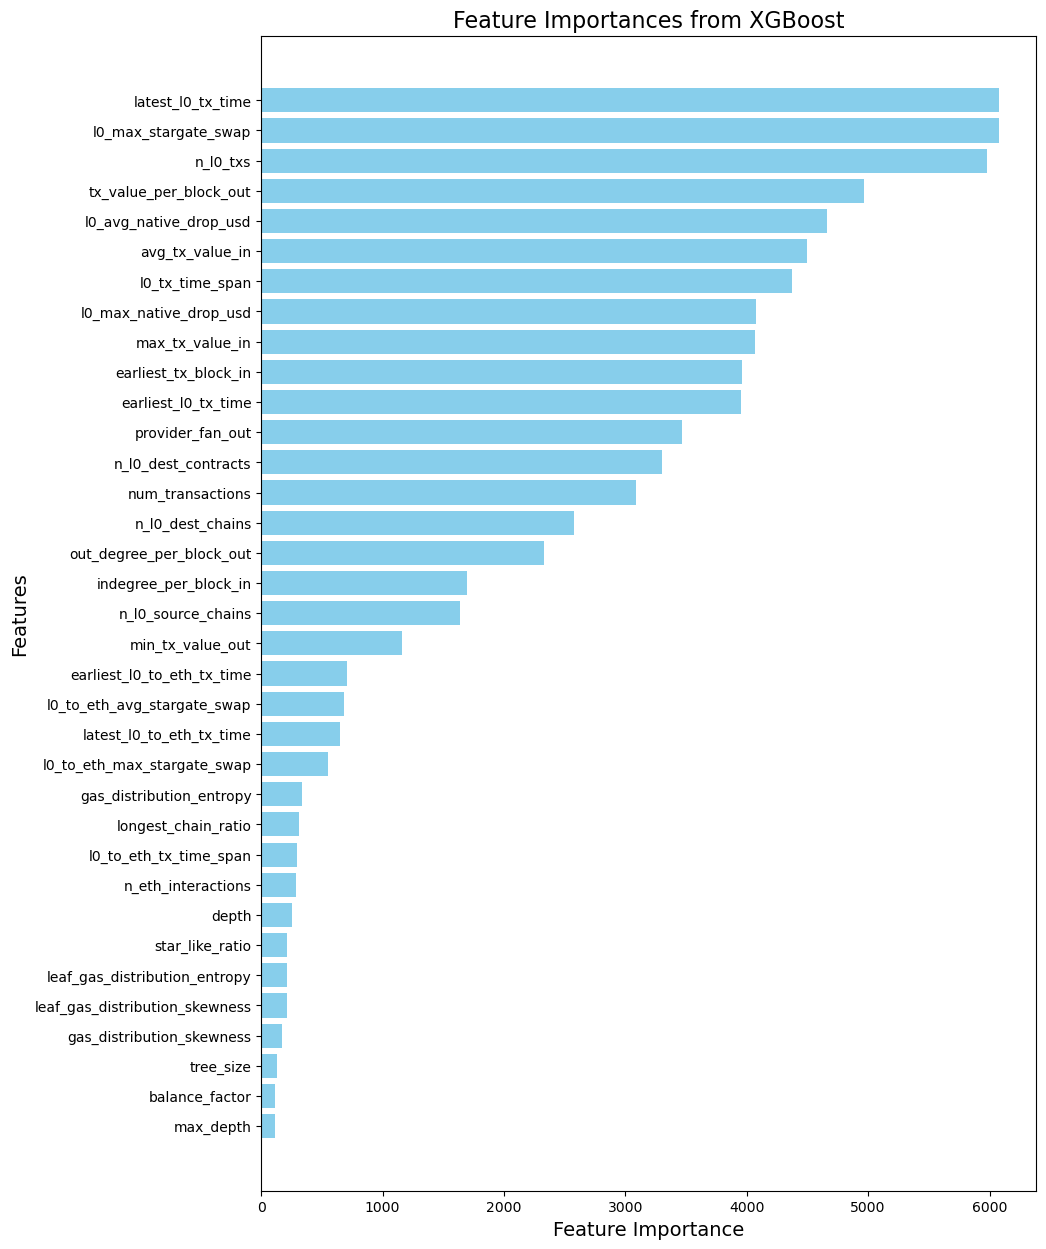

In [10]:
master_df_subset = master_df.copy()

X_train_balanced, y_train_balanced, X_val, y_val, X_test, y_test = split_and_balance_data(
    master_df_subset,
    label_column='sybil',
    test_size=0.3,
    val_size=0.3,
    random_state=42
)

# Train and evaluate the model
model, best_threshold = train_and_evaluate_model(
    X_train_balanced, 
    y_train_balanced, 
    X_val, 
    y_val, 
    selected_features, 
    params
)


# Nontrivial Trees (Provider is Interactor)


Confusion Matrix (Validation Set):
[[7149   34]
 [  66  270]]

Classification Report (Validation Set):
              precision    recall  f1-score   support

       False      0.991     0.995     0.993      7183
        True      0.888     0.804     0.844       336

    accuracy                          0.987      7519
   macro avg      0.940     0.899     0.918      7519
weighted avg      0.986     0.987     0.986      7519

Optimal threshold (Validation Set): 0.5031620264053345

Confusion Matrix (Optimal Threshold, Validation Set):
[[7149   34]
 [  66  270]]

Classification Report (Optimal Threshold, Validation Set):
              precision    recall  f1-score   support

       False      0.991     0.995     0.993      7183
        True      0.888     0.804     0.844       336

    accuracy                          0.987      7519
   macro avg      0.940     0.899     0.918      7519
weighted avg      0.986     0.987     0.986      7519

Time elapsed: 6.188836574554443


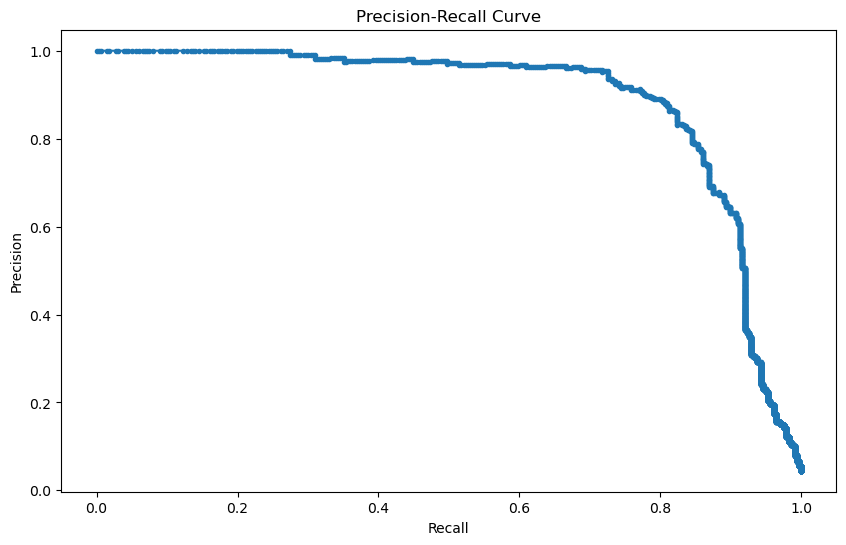

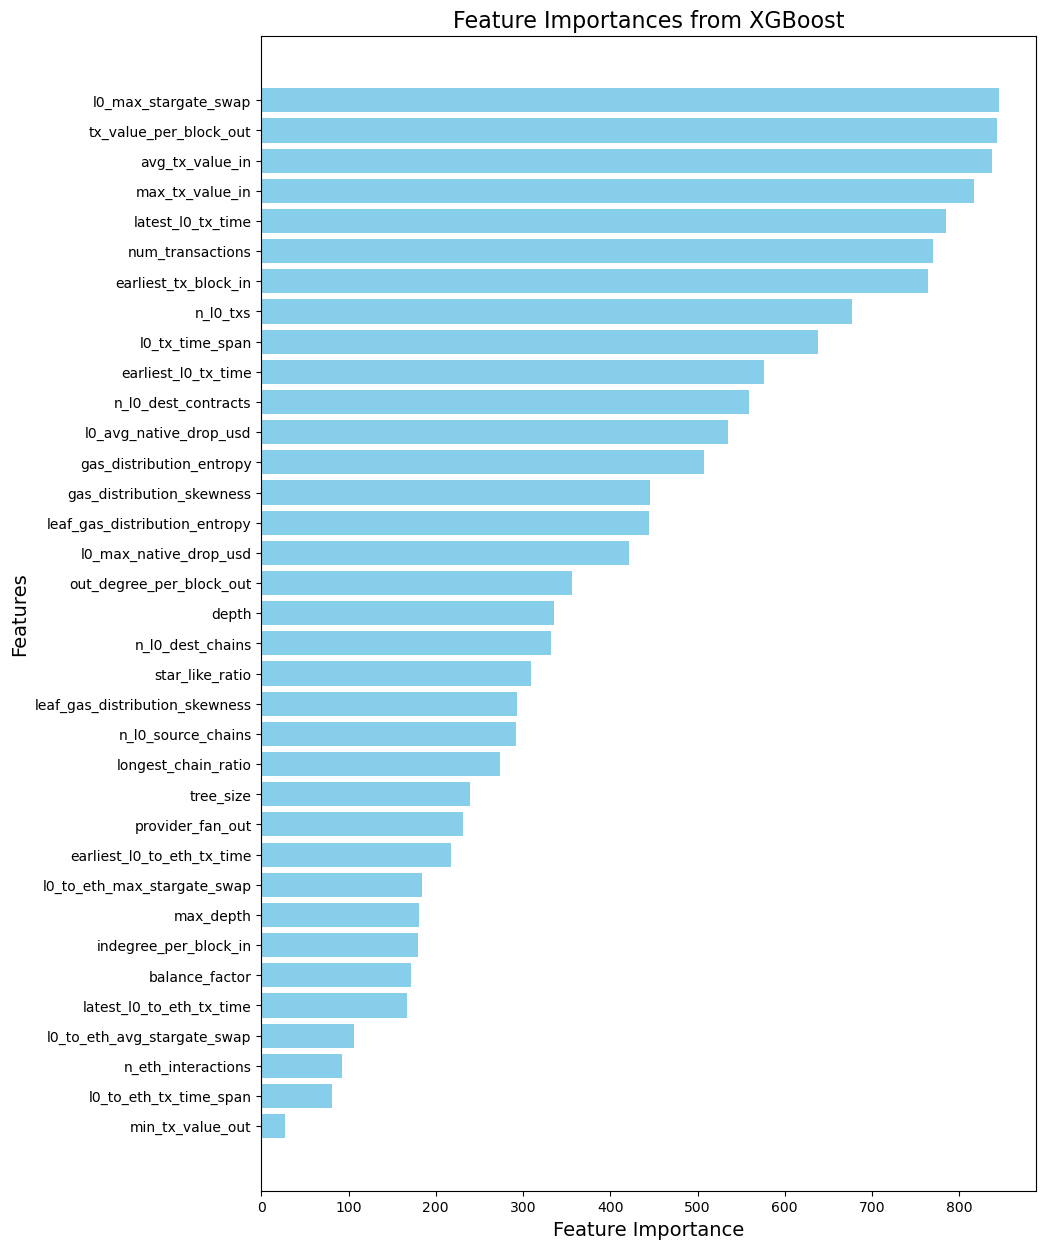

In [11]:
master_df = master_df_orig.copy()

master_df_subset = master_df[master_df.provider_is_interactor]

X_train_balanced, y_train_balanced, X_val, y_val, X_test, y_test = split_and_balance_data(master_df_subset)

# Train and evaluate the model
model, best_threshold = train_and_evaluate_model(
    X_train_balanced, 
    y_train_balanced, 
    X_val, 
    y_val, 
    selected_features, 
    params
)

# Degenerate Trees (Provider is Labeled)

Confusion Matrix (Validation Set):
[[59230   862]
 [  884  2451]]

Classification Report (Validation Set):
              precision    recall  f1-score   support

       False      0.985     0.986     0.985     60092
        True      0.740     0.735     0.737      3335

    accuracy                          0.972     63427
   macro avg      0.863     0.860     0.861     63427
weighted avg      0.972     0.972     0.972     63427

Optimal threshold (Validation Set): 0.35170674324035645

Confusion Matrix (Optimal Threshold, Validation Set):
[[59102   990]
 [  787  2548]]

Classification Report (Optimal Threshold, Validation Set):
              precision    recall  f1-score   support

       False      0.987     0.984     0.985     60092
        True      0.720     0.764     0.741      3335

    accuracy                          0.972     63427
   macro avg      0.854     0.874     0.863     63427
weighted avg      0.973     0.972     0.972     63427

Time elapsed: 33.147852420806885


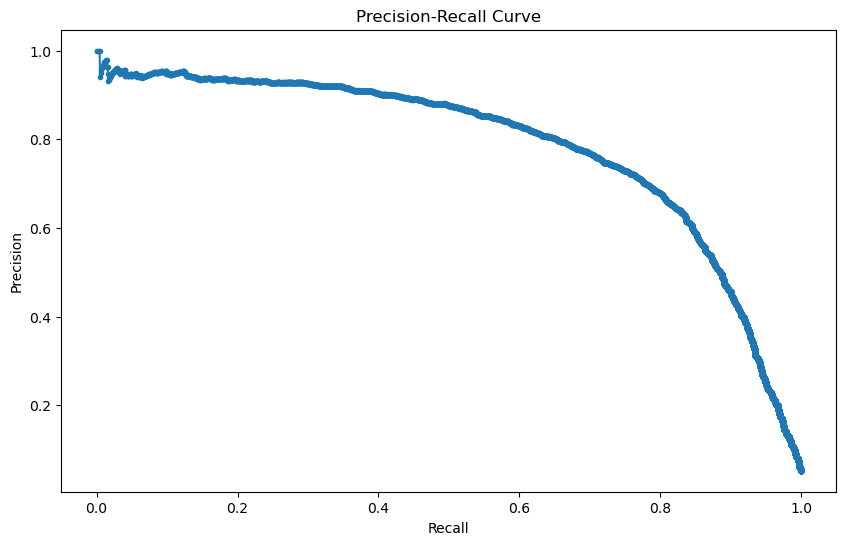

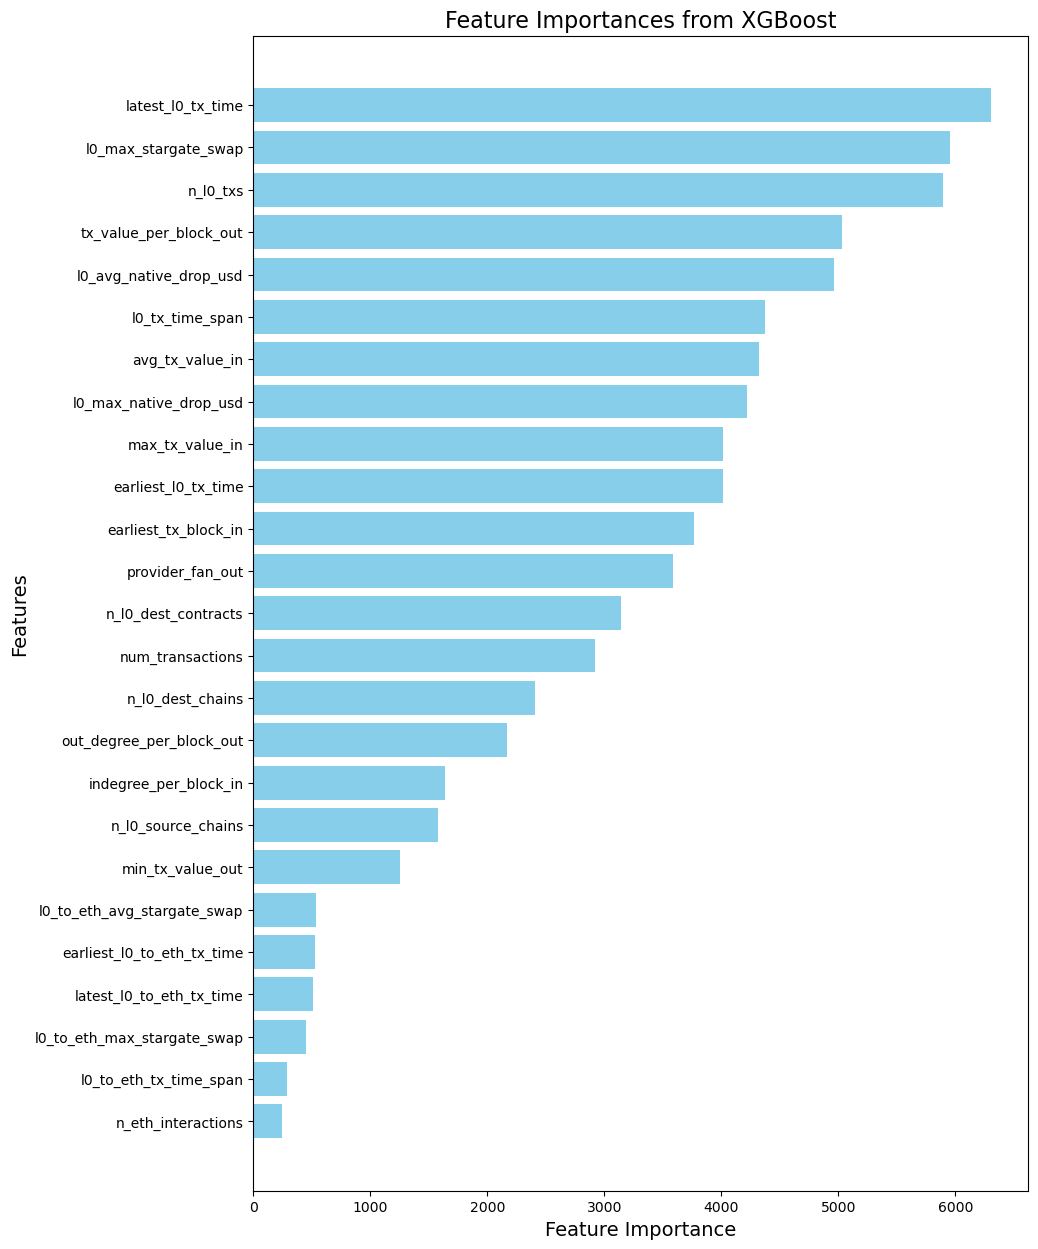

In [12]:
master_df = master_df_orig.copy()

master_df_subset = master_df[master_df.provider_is_labeled & ~master_df.provider_is_interactor]

X_train_balanced, y_train_balanced, X_val, y_val, X_test, y_test = split_and_balance_data(master_df_subset)

# Train and evaluate the model
model, best_threshold = train_and_evaluate_model(
    X_train_balanced, 
    y_train_balanced, 
    X_val, 
    y_val, 
    selected_features, 
    params
)

# Trivial Trees (Provider is Unlabeled Non-Interactor)

Confusion Matrix (Validation Set):
[[20187    20]
 [   92    62]]

Classification Report (Validation Set):
              precision    recall  f1-score   support

       False      0.995     0.999     0.997     20207
        True      0.756     0.403     0.525       154

    accuracy                          0.994     20361
   macro avg      0.876     0.701     0.761     20361
weighted avg      0.994     0.994     0.994     20361

Optimal threshold (Validation Set): 0.35702481865882874

Confusion Matrix (Optimal Threshold, Validation Set):
[[20182    25]
 [   85    69]]

Classification Report (Optimal Threshold, Validation Set):
              precision    recall  f1-score   support

       False      0.996     0.999     0.997     20207
        True      0.734     0.448     0.556       154

    accuracy                          0.995     20361
   macro avg      0.865     0.723     0.777     20361
weighted avg      0.994     0.995     0.994     20361

Time elapsed: 11.479596853256226


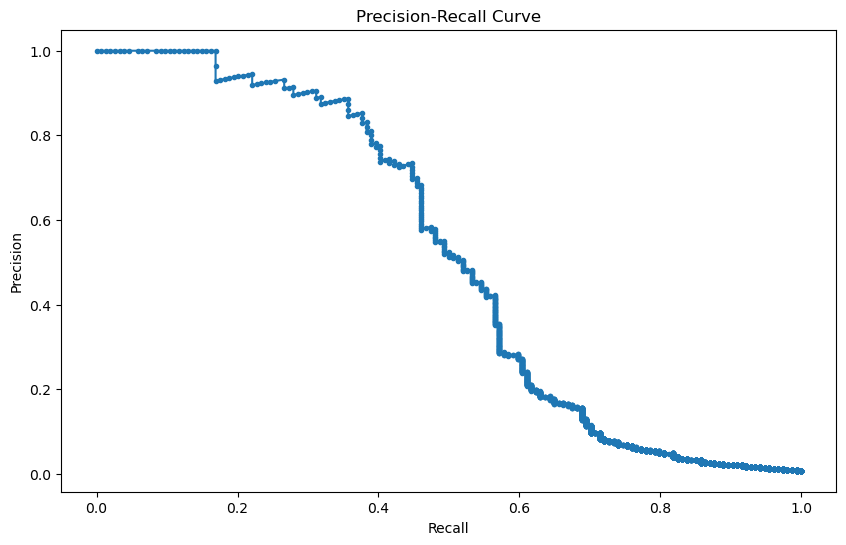

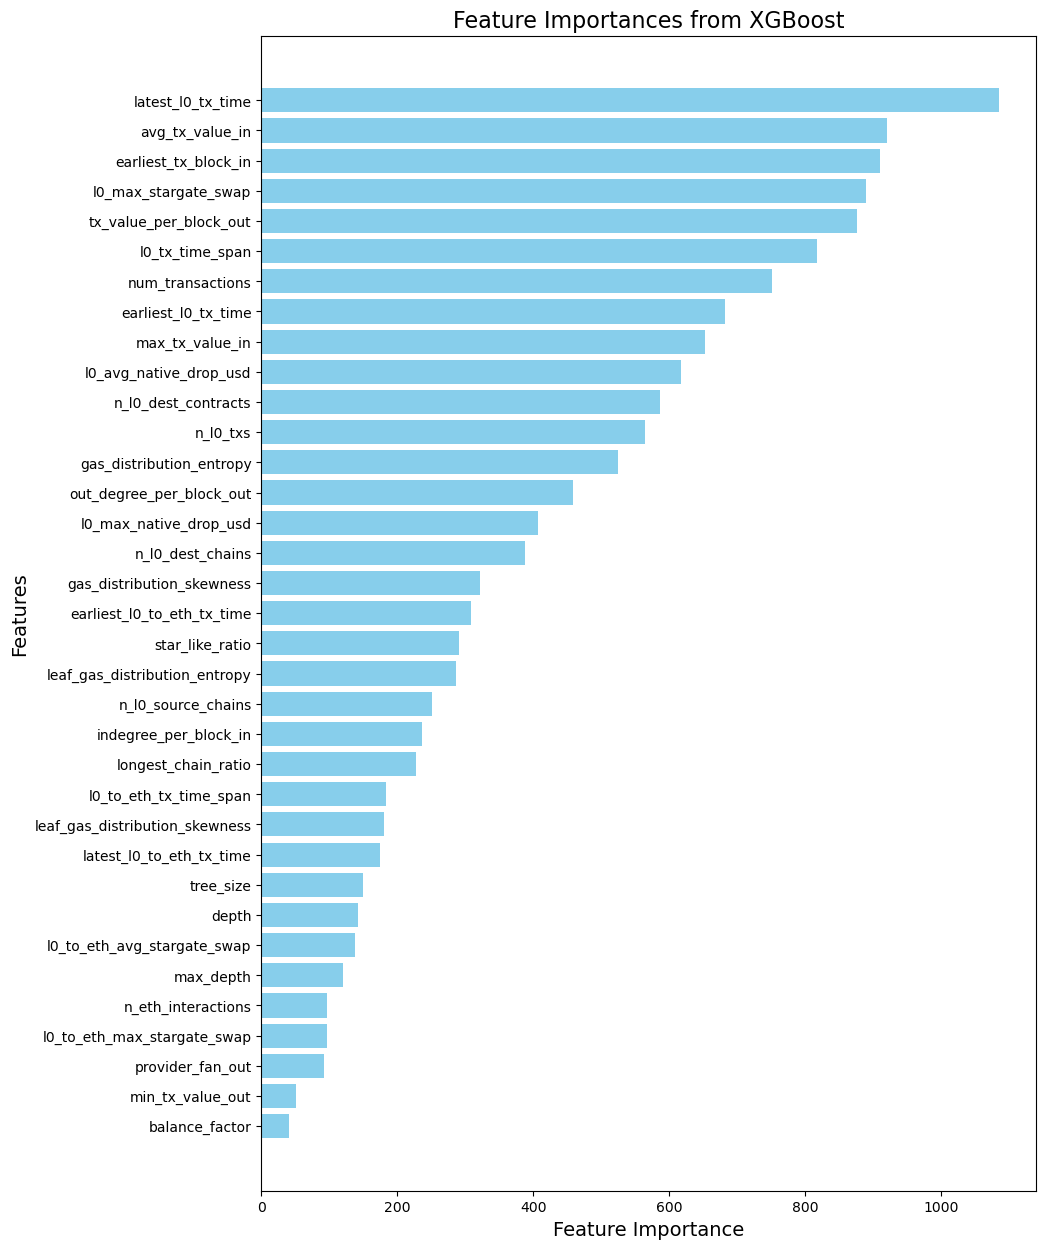

In [13]:
master_df = master_df_orig.copy()

master_df_subset = master_df[~master_df.provider_is_labeled & ~master_df.provider_is_interactor]

X_train_balanced, y_train_balanced, X_val, y_val, X_test, y_test = split_and_balance_data(master_df_subset)

# Train and evaluate the model
model, best_threshold = train_and_evaluate_model(
    X_train_balanced, 
    y_train_balanced, 
    X_val, 
    y_val, 
    selected_features, 
    params
)

In [14]:
selected_features

['min_tx_value_out',
 'leaf_gas_distribution_entropy',
 'longest_chain_ratio',
 'provider_fan_out',
 'l0_to_eth_max_stargate_swap',
 'l0_avg_native_drop_usd',
 'l0_max_native_drop_usd',
 'l0_to_eth_tx_time_span',
 'leaf_gas_distribution_skewness',
 'max_depth',
 'balance_factor',
 'l0_to_eth_avg_stargate_swap',
 'tree_size',
 'star_like_ratio',
 'branching_factor',
 'earliest_l0_to_eth_tx_time',
 'l0_max_stargate_swap',
 'l0_tx_time_span',
 'earliest_tx_block_in',
 'n_l0_dest_contracts',
 'max_tx_value_in',
 'latest_l0_tx_time',
 'num_transactions',
 'gas_distribution_entropy',
 'n_l0_txs',
 'out_degree_per_block_out',
 'gas_distribution_skewness',
 'avg_tx_value_in',
 'latest_l0_to_eth_tx_time',
 'n_l0_source_chains',
 'n_l0_dest_chains',
 'n_eth_interactions',
 'tx_value_per_block_out',
 'earliest_l0_tx_time',
 'depth',
 'indegree_per_block_in']